# MNE-RSA: representational similarity analysis on source-level MEG data
<img src="images/adept.png" width="220" style="float: right">

While sensor-level RSA is useful to get a first impression of how neural representations unfold over time, it is not really suited to study differences between brain regions.
For this, you want to so RSA in a searchlight pattern across the cortex.

The knowledge you have gained from your sensor-level analysis will serve you well for this part, as the API of MNE-RSA is mostly the same across sensor- and source-level analysis.
However, performing a searchlight analysis is a heavy computation that can take a lot of time.
Hence, we will also learn about the API regarding restricting the analysis to parts of the data in several ways.

In the cell below, update the `data_path` variable to point to where you have extracted the [`rsa-data.zip`](https://github.com/wmvanvliet/neuroscience_tutorials/releases/download/2/rsa-data.zip) file to.

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 90  # Tune this to make figures bigger/smaller

# Set this to where you've extracted `data.zip` to
data_path = "data"

We'll start by loading the `epochs` again, but this time, we will restrict them to only two experimental conditions:
the first presentations of famous faces versus scrambled faces.
This will reduce the number of rows/columns in our RDMs and hence speed up computing and comparing them.

In [2]:
import mne
epochs = mne.read_epochs(f"{data_path}/sub-02/sub-02-epo.fif")
epochs = epochs[['face/famous/first', 'scrambled/first']]
epochs

Reading C:\Users\wmvan\projects\mne-rsa\doc\tutorial\data\sub-02\sub-02-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    2900.00 ms
        0 CTF compensation matrices available
Adding metadata with 2 columns
879 matching events found
No baseline correction applied
0 projection items activated


<EpochsFIF | 297 events (all good), -0.2 – 2.9 s (baseline -0.2 – 0 s), ~489.7 MiB, data loaded, with metadata,
 'face/famous/first': 147
 'scrambled/first': 150>

When we select a subset of epochs, the `epochs.metadata` field is likewise updated to match the new selection.
This feature is one of the main reasons to use the `.metadata` field instead of keeping a separate `DataFrame` manually.

In [3]:
epochs.metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 4 to 884
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   trigger  297 non-null    int64 
 1   file     297 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.0+ KB


This means we can use the `epochs.metadata["file"]` column to restrict the pixel and FaceNet RDMs to just those images still present in the MEG data.

In the cell below, we read the images and FaceNet embeddings and select the proper rows from the data matrices and use `compute_dsm` to compute the appropriate RDMs.

In [29]:
from glob import glob
from PIL import Image
import numpy as np

files = sorted(glob(f"{data_path}/stimuli/*.bmp"))
pixels = np.array([np.array(Image.open(f)) for f in files])

store = np.load(f"{data_path}/stimuli/facenet_embeddings.npz")
filenames = store["filenames"]
embeddings = store["embeddings"]

# Select the proper filenames
epochs_filenames = set(epochs.metadata["file"]) 
selection = [f in epochs_filenames for f in filenames]
filenames = filenames[selection]

# Select the proper rows from `pixels` and `embeddings` and compute the RDMs.
from mne_rsa import compute_rdm
pixel_rdm = compute_rdm(pixels[selection])
facenet_rdm = compute_rdm(embeddings[selection])

Executing the cell below will test whether the RDMs have been properly constructed and plot them.

The RDMs look just right! 😊


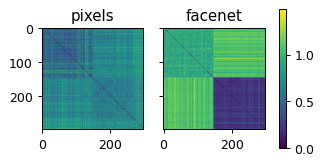

In [30]:
from mne_rsa import plot_rdms
from scipy.spatial.distance import squareform
if len(pixel_rdm) != len(facenet_rdm):
    print("The pixel and FaceNet RDMs are of difference sizes, that can't be right. 🤔")
elif len(pixel_rdm) != 43956:
    print("Looks like the RDMs do not have the correct rows. 🤔")
elif squareform(pixel_rdm)[:150, :150].mean() >= squareform(pixel_rdm)[150:, 150:].mean():
    print("The pixels RDM doesn't look quite right. Make sure the rows are in alphabetical filename order. 🤔")
elif squareform(facenet_rdm)[:150, :150].mean() <= squareform(facenet_rdm)[150:, 150:].mean():
    print("The FaceNet RDM doesn't look quite right. Make sure the rows are in alphabetical filename order. 🤔")
else:
    print("The RDMs look just right! 😊")
    plot_rdms([pixel_rdm, facenet_rdm], names=["pixels", "facenet"]);

As was the case with the sensor-level RSA, we also need the `y` array that assigns a number to each epoch indicating which one of the 297 images was shown, taking care to assign numbers that respect the order in which the images appear in `pixel_dsm` and `facenet_dsm`.

In [35]:
y = np.searchsorted(filenames, epochs.metadata.file)

## To source space!

In order to perform RSA in source space, we must create source estimates for the epochs.
There's many different ways to do this, for example you'll learn about beamformers during this workshop, but here we're going to use the one that is fastest.
If we use MNE, we can use a pre-computed inverse operator and apply it to the epochs to quickly get source estimates.

In [38]:
from mne.minimum_norm import read_inverse_operator, apply_inverse_epochs
inv = read_inverse_operator(f"{data_path}/sub-02/sub-02-inv.fif")
stcs = apply_inverse_epochs(epochs, inv, lambda2=1/9)

Reading inverse operator decomposition from C:\Users\wmvan\projects\mne-rsa\doc\tutorial\data\sub-02\sub-02-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    204 x 204 full covariance (kind = 1) found.
    Noise covariance matrix read.
    6150 x 6150 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    6150 x 6150 diagonal covariance (kind = 6) found.
    Orientation priors read.
    6150 x 6150 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Source spaces transformed to the inverse solution coordinate frame
Preparing t

The result is a list of 297 `SourceEstimate` objects. Here are the first 5 of them:

In [39]:
stcs[:5]

[<SourceEstimate | 2050 vertices, subject : sub-02, tmin : -200.0 (ms), tmax : 2899.9999999999995 (ms), tstep : 4.545454545454545 (ms), data shape : (2050, 683), ~10.7 MiB>,
 <SourceEstimate | 2050 vertices, subject : sub-02, tmin : -200.0 (ms), tmax : 2899.9999999999995 (ms), tstep : 4.545454545454545 (ms), data shape : (2050, 683), ~10.7 MiB>,
 <SourceEstimate | 2050 vertices, subject : sub-02, tmin : -200.0 (ms), tmax : 2899.9999999999995 (ms), tstep : 4.545454545454545 (ms), data shape : (2050, 683), ~10.7 MiB>,
 <SourceEstimate | 2050 vertices, subject : sub-02, tmin : -200.0 (ms), tmax : 2899.9999999999995 (ms), tstep : 4.545454545454545 (ms), data shape : (2050, 683), ~10.7 MiB>,
 <SourceEstimate | 2050 vertices, subject : sub-02, tmin : -200.0 (ms), tmax : 2899.9999999999995 (ms), tstep : 4.545454545454545 (ms), data shape : (2050, 683), ~10.7 MiB>]

<img src="images/distances.svg" style="float: right; margin-left: 50px" width="300">

The plan is to perform RSA in a searchlight pattern, not only as a sliding window through time, but also sliding across different locations across the cortex.
To this end, we'll define spatial patches with a certain radius, and only source points that fall within a patch are taken into account when computing the RDM for that patch.
The cortex is heavily folded and ideally we define distances between source point as the shortest path along the cortex, what is known as the geodesic distance, rather than straight euclidean distance between the XYZ coordinates.
MNE-Python is here to help us out in this regard, as it contains a function to compute such distances and store them within the [`SourceSpaces`](https://mne.tools/stable/generated/mne.SourceSpaces.html) object (through the [`add_source_space_distances`](https://mne.tools/stable/generated/mne.add_source_space_distances.html) function).

Let's load the file containing the proper source space with pre-computed geodesic distances between source points:

In [40]:
from mne import read_source_spaces
src = read_source_spaces(f"{data_path}/freesurfer/sub-02/bem/sub-02-oct5-src.fif")

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read


To speed things up, let's restrict the analysis to only the occipital, parietal and temporal areas on the left hemisphere.
There are several ways to tell MNE-RSA which source points to use, and one of the most convenient ones is to use [`mne.Label`](https://mne.tools/stable/generated/mne.Label.html) objects.
This allows us to define the desired areas using the "aparc" atlas that FreeSurfer has constructed for us:

In [41]:
rois = mne.read_labels_from_annot("sub-02", parc="aparc", subjects_dir=f"{data_path}/freesurfer", hemi="lh")

# These are the regions we're interested in
roi_sel = ['inferiortemporal-lh', 'middletemporal-lh', 'fusiform-lh', 'bankssts-lh', 'inferiorparietal-lh', 'lateraloccipital-lh', 'lingual-lh', 'pericalcarine-lh', 'cuneus-lh', 'supramarginal-lh', 'superiorparietal-lh']
rois = [r for r in rois if r.name in roi_sel]

Reading labels from parcellation...
   read 34 labels from C:\Users\wmvan\projects\mne-rsa\doc\tutorial\data\freesurfer\sub-02\label\lh.aparc.annot


## Source-space RSA

Time to actually perform the RSA in source space. The function you need is [`rsa_stcs`](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.rsa_stcs.html).
Take a look at the documentation of that function, which should look familiar is it is very similar to [`rsa_epochs`](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.rsa_epochs.html) that you have used before.

We will perform RSA on the source estimates, using the pixel and FaceNet RDMs as model RDMs.
Searchlight patches swill have a spatial radius of 2cm (=0.02 meters) and a temporal radius of 50 ms (=0.05 seconds).
We will restrict the analysis to  0.0 to 0.5 seconds after stimulus onset and to the cortical regions (`rois`) we've selected above.
We can optionally set `n_jobs=-1` to use all CPU cores and `verbose=True` to show a progress bar.
 
Depending on the speed of your computer, this may take anywhere from a few seconds to a few minutes to complete.

In [43]:
from mne_rsa import rsa_stcs
stc_rsa = rsa_stcs(stcs, [pixel_rdm, facenet_rdm], src=src, y=y, tmin=0, tmax=0.5, sel_vertices=rois,
                   spatial_radius=0.02, temporal_radius=0.05, verbose=True, n_jobs=-1)

Restricting source space to 2050 out of [1026 1026] vertices.
Restricting source space to 2050 out of [1025 1025] vertices.
Performing RSA between SourceEstimates and 2 model RDM(s)
    Spatial radius: 0.02 meters
    Using 373 vertices
    Temporal radius: 11 samples
    Time interval: 0-0.5 seconds
    Number of searchlight patches: 41030


  0%|                                                                                                                                                                               | 0/41030 [00:00<?, ?patch/s]

Creating spatio-temporal searchlight patches


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41030/41030 [02:51<00:00, 239.84patch/s]


If everyting went as planned, executing the cell below will plot the result.

In [44]:
# For clarity, only show positive RSA scores
stc_rsa[0].data[stc_rsa[0].data < 0] = 0
stc_rsa[1].data[stc_rsa[1].data < 0] = 0

# Show the RSA maps for both the pixel and FaceNet RDMs
brain_pixels = stc_rsa[0].plot("sub-02", subjects_dir=f"{data_path}/freesurfer", hemi="both", initial_time=0.081, views="ventral", title="pixels")
brain_facenet = stc_rsa[1].plot("sub-02", subjects_dir=f"{data_path}/freesurfer", hemi="both", initial_time=0.180, views="parietal", title="FaceNet")

Using pyvistaqt 3d backend.
Using control points [0.02692218 0.03490713 0.07436469]
False
Could not estimate rigid Talairach alignment, using identity matrix
Using control points [0.03274756 0.04136883 0.110632  ]
False
Could not estimate rigid Talairach alignment, using identity matrix


If you've made it this far, you have successfully completed your first sensor-level RSA! 🎉 This is the end of this notebook. In the next notebook, we will discuss group-level analysis and statistics.

<center>
<a href="statistics.ipynb"><img width="200" src="images/expert.png"></a><br>
<a href="statistics.ipynb" style="font-size: 20pt">>>>>> Continue to statistics >>>>></a>
</center>